### Experiment: Formulation

**Question**: Which option is better?
- A 2D data formulation (`channels` * `samples`)
- A topological 3D formulation (`x` * `y` * `samples`) that positions the channels similar to their physical location

**Hypothesis**: The topological 3D formulation should have more inherent information regarding the relative location of each electrode, meaning that inter-channel similarities should be easier to extract. A topological 3D formulation should therefore be better at extracting features with regard to physical location.

**Result**:

#### Part 1: Investigation

In [7]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

##### Show electrode montage layout

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_11536/941089869.py:4: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_11536/941089869.py:8: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


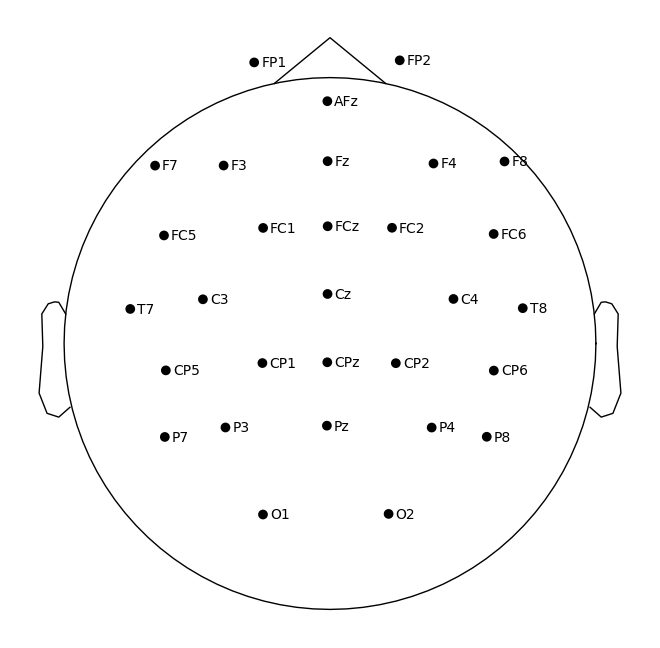

In [9]:
raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

montage = raw.get_montage()
plot = montage.plot()
plt.show()

##### Replicate layout
Method of creating a sparse array retaining physical nearness adapted from Liu, Yang (2021)

In [12]:
CHANNELS_2D = np.array(
    [
        ["NA", "Fp1", "NA", "Fp2", "NA"],
        ["NA", "NA", "AFz", "NA", "NA"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["NA", "O1", "NA", "O2", "NA"],
    ],
    dtype=str,
)
print(pd.DataFrame(CHANNELS_2D))

     0    1    2    3    4
0   NA  Fp1   NA  Fp2   NA
1   NA   NA  AFz   NA   NA
2   F7   F3   Fz   F4   F8
3  FC5  FC1  FCz  FC2  FC6
4   T7   C3   Cz   C4   T8
5  CP5  CP1  CPz  CP2  CP6
6   P7   P3   Pz   P4   P8
7   NA   O1   NA   O2   NA


#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from hmpai.training import split_data_on_participants, train_and_evaluate, k_fold_cross_validate, get_compile_kwargs
from hmpai.normalization import *
from hmpai.models import SAT1Base, SAT1Topological, SAT1TopologicalConv
from hmpai.utilities import CHANNELS_2D, print_results
import tensorflow as tf
import gc
from pathlib import Path
import xarray as xr
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-22 11:39:54.436310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 11:39:55.104777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

logs_path = Path("../logs/exp_formulation/")

height, width = CHANNELS_2D.shape

##### Base model, no topological formulation

In [5]:
tf.keras.backend.clear_session()
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "base"},
    "additional_name": f"formulation-base",
}
results = k_fold_cross_validate(
    data, model, 5, normalization_fn=norm_dummy, train_kwargs=train_kwargs
)
print_results(results)
del model
gc.collect()

2023-10-22 11:17:09.111613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:17:09.132349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:17:09.132430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:17:09.134295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:17:09.134365: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 11:17:12.504596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 11:17:13.190027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 11:17:13.511585: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a997db9af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 11:17:13.511616: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 11:17:13.517918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 11:17:13.624788: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 18s 14ms/step - loss: 3.6951 - accuracy: 0.7296 - val_loss: 0.5749 - val_accuracy: 0.7928
Epoch 2/20
997/997 [==============================] - 14s 14ms/step - loss: 2.7676 - accuracy: 0.7991 - val_loss: 0.5143 - val_accuracy: 0.8091
Epoch 3/20
997/997 [==============================] - 14s 14ms/step - loss: 2.4049 - accuracy: 0.8235 - val_loss: 0.4932 - val_accuracy: 0.8187
Epoch 4/20
997/997 [==============================] - 14s 14ms/step - loss: 2.2221 - accuracy: 0.8377 - val_loss: 0.4977 - val_accuracy: 0.8162
Epoch 5/20
997/997 [==============================] - 14s 14ms/step - loss: 2.0162 - accuracy: 0.8489 - val_loss: 0.4862 - val_accuracy: 0.8342
Epoch 6/20
997/997 [==============================] - 14s 14ms/step - loss: 1.8317 - accuracy: 0.8642 - val_loss: 0.4796 - val_accuracy: 0.8255
Epoch 7/20
997/997 [==============================] - 14s 14ms/step - loss: 1.7039 - accuracy: 0.8732 - val_loss: 0.4883 - val_accuracy: 0.8307
Epo

2738

##### Topological model without topological convolution

In [3]:
tf.keras.backend.clear_session()
model = SAT1Topological(width, height, len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological-noconv"},
    "additional_name": f"formulation-topological-noconv",
}
results = k_fold_cross_validate(
    data,
    model,
    5,
    normalization_fn=norm_dummy,
    gen_kwargs={"shape_topological": True},
    train_kwargs=train_kwargs,
)
print_results(results)
del model
gc.collect()

2023-10-22 11:27:38.644430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:27:38.669528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:27:38.669609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:27:38.672015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:27:38.672086: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 11:27:42.281692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 11:27:43.020366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 11:27:43.302279: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1e78906e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 11:27:43.302314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 11:27:43.308296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 11:27:43.416363: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 20s 17ms/step - loss: 3.7275 - accuracy: 0.7235 - val_loss: 0.5821 - val_accuracy: 0.7881
Epoch 2/20
997/997 [==============================] - 17s 17ms/step - loss: 2.7216 - accuracy: 0.8012 - val_loss: 0.5060 - val_accuracy: 0.8152
Epoch 3/20
997/997 [==============================] - 17s 17ms/step - loss: 2.3688 - accuracy: 0.8237 - val_loss: 0.4864 - val_accuracy: 0.8132
Epoch 4/20
997/997 [==============================] - 17s 17ms/step - loss: 2.1493 - accuracy: 0.8419 - val_loss: 0.4826 - val_accuracy: 0.8204
Epoch 5/20
997/997 [==============================] - 17s 17ms/step - loss: 1.9691 - accuracy: 0.8508 - val_loss: 0.5135 - val_accuracy: 0.8169
Epoch 6/20
997/997 [==============================] - 17s 17ms/step - loss: 1.8241 - accuracy: 0.8647 - val_loss: 0.4842 - val_accuracy: 0.8226
Epoch 7/20
254/254 [==============================] - 3s 11ms/step
Fold 1: Accuracy: 0.8203740157480315
Fold 1: F1-Score: 0.8173291191209013
Fold 2

2738

##### Topological model with topological convolution

In [3]:
tf.keras.backend.clear_session()
model = SAT1TopologicalConv(width, height, len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological"},
    "additional_name": f"formulation-topological",
}
results = k_fold_cross_validate(
    data,
    model,
    5,
    normalization_fn=norm_dummy,
    gen_kwargs={"shape_topological": True},
    train_kwargs=train_kwargs,
)
print_results(results)
del model
gc.collect()

2023-10-22 11:40:02.526422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:40:02.550335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:40:02.550417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:40:02.551930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 11:40:02.552001: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-22 11:40:06.178095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-22 11:40:06.882551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-22 11:40:07.121862: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb70be36ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 11:40:07.121901: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-22 11:40:07.128192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 11:40:07.236749: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 17s 14ms/step - loss: 3.4560 - accuracy: 0.7534 - val_loss: 0.5655 - val_accuracy: 0.7928
Epoch 2/20
997/997 [==============================] - 14s 14ms/step - loss: 2.6016 - accuracy: 0.8135 - val_loss: 0.5202 - val_accuracy: 0.8081
Epoch 3/20
997/997 [==============================] - 14s 13ms/step - loss: 2.1847 - accuracy: 0.8380 - val_loss: 0.4865 - val_accuracy: 0.8248
Epoch 4/20
997/997 [==============================] - 14s 13ms/step - loss: 2.0290 - accuracy: 0.8512 - val_loss: 0.5053 - val_accuracy: 0.8228
Epoch 5/20
997/997 [==============================] - 14s 14ms/step - loss: 1.8316 - accuracy: 0.8643 - val_loss: 0.5728 - val_accuracy: 0.8145
Epoch 6/20
997/997 [==============================] - 14s 14ms/step - loss: 1.8261 - accuracy: 0.8662 - val_loss: 0.5638 - val_accuracy: 0.8255
Epoch 7/20
254/254 [==============================] - 3s 10ms/step
Fold 1: Accuracy: 0.8225885826771654
Fold 1: F1-Score: 0.8207762270476501
Fold 2

2540

View results in TensorBoard

In [6]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_formulation/

2023-10-13 14:05:48.740655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
